# Notebook III : La factorisation des entiers et l'algorithme de Shor

## Partie I : L'algorithme de l'estimation de phase quantique 

In [54]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeSydneyV2 
import numpy as np
import qiskit_aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import gcd



In [55]:
#from c12sim import *
from simulators.qiskit import QiskitSimulator
from qiskit_backend.c12sim_backend import C12simBackend 

In [56]:
### Choisir un backend 
#backend = AerSimulator.from_backend(FakeSydneyV2()) ###IBM's fake backend
backend = C12simBackend(idle=True, num_qubits=13)### C12's backend with idle qubit errors

### Le circuit pour la Transformée de Fourier (QFT)

In [57]:
# Le circuit pour QFT
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

#Inverse Quantum Fourier Transform
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)

#### Étape 1 : Mise en place d'un circuit QPE avec quatre qubits de comptage



Choisissons une porte de phase avec $\theta = \frac{1}{3}$ comme exemple unitaire simple pour tester la création d'un circuit QPE.  Nous utiliserons ici la `PhaseGate` de Qiskit qui applique $P|1\rangle{}=e^{i\lambda}|1\rangle{}$.  Puisque nous voulons examiner l'EPQ sous une unité de la forme $U|1\rangle{}=e^{i2\pi \theta}$, nous devrions mettre $\lambda=\frac{2\pi}{3}$.

Créez un circuit QPE avec quatre qubits de comptage et nommez le circuit `qpe4`.  Il peut être utile de définir deux objets `QuantumRegister`, un pour le « système » où l'unité sera appliquée et un pour l'endroit où l'information de phase sera stockée.

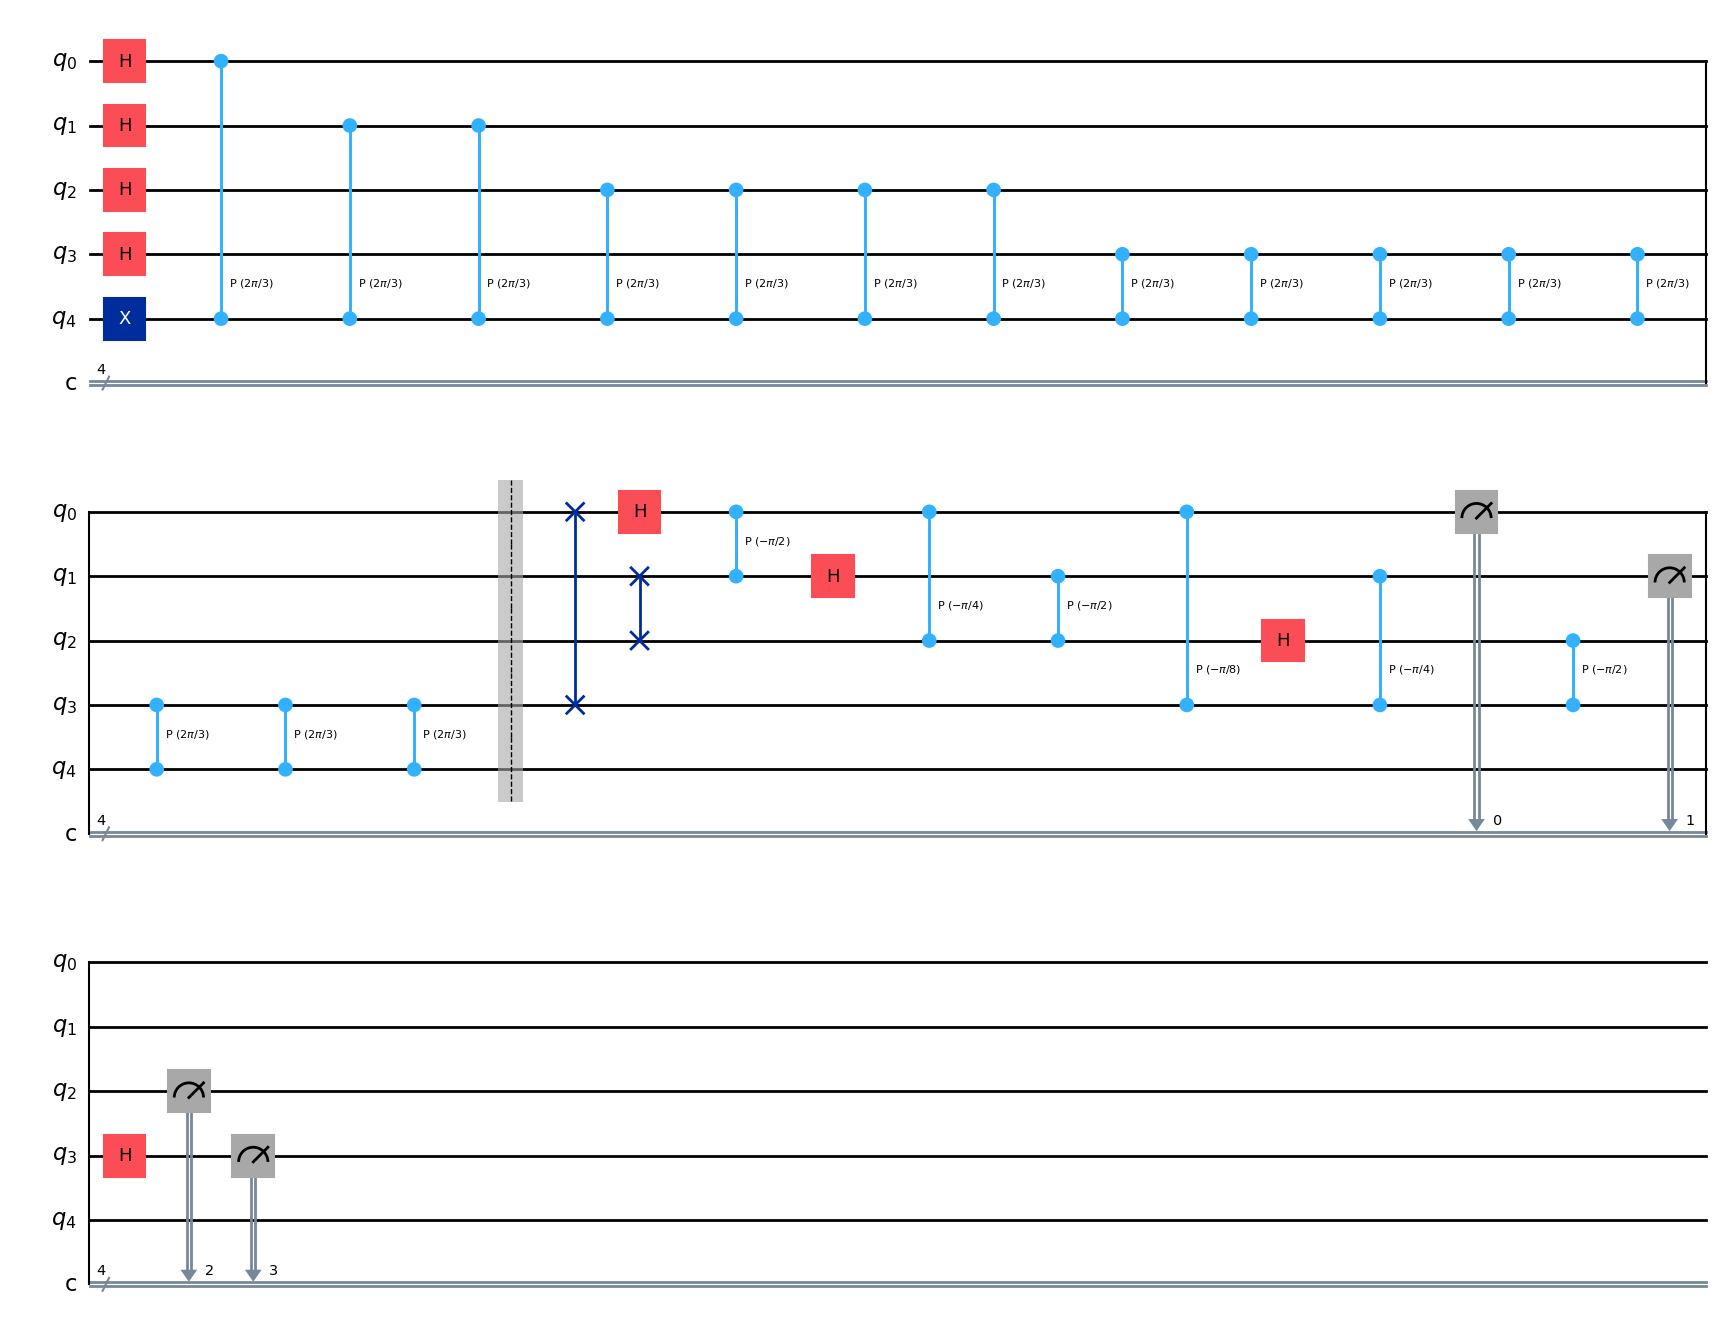

In [58]:
phase_register_size = 4
qpe4 = QuantumCircuit(phase_register_size+1, phase_register_size)

### Ajouter votre code ici

# Appliquer QFT inversée
#qpe4 = qpe4.compose(QFT(4, inverse=True), [0,1,2,3])
qft_dagger(qpe4, 4)
#Mesure
for n in range(4):
    qpe4.measure(n,n)

qpe4.draw('mpl')

Utilisez maintenant `AerSimulator` pour simuler ce circuit et tracez l'histogramme des résultats. Utilisez 2000 clichés.

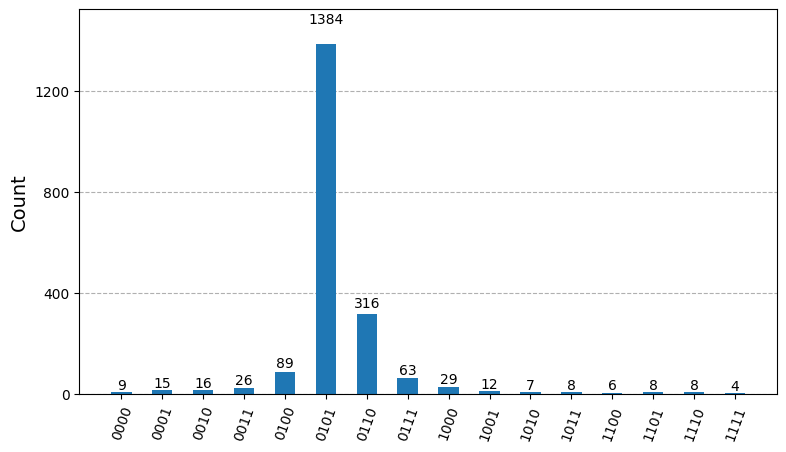

In [59]:
## Exécuter cette cellule pour simuler “qpe4” et tracer l'histogramme du résultat

result = AerSimulator().run(qpe4, shots=2000).result()

## Obtenir et imprimer les comptes
counts_qpe4 = result.get_counts(qpe4)
plot_histogram(counts_qpe4, figsize=(9,5))


Ecrivez ensuite une fonction pour traiter les chaînes de bits dans l'estimation de $\theta$.  Rappelons que l'estimation de la phase s'écrit sous la forme suivante :

$$ \theta = 0.\theta_1\theta_2\theta_3...\theta_t = \frac{\theta_1}{2^1} + \frac{\theta_2}{2^2} + \frac{\theta_3}{2^3} + ... + \frac{\theta_t}{2^t} $$

où $\theta_i = \{0,1\}$.  Quelle est la phase estimée ?  Quelle est la puissance de 2 la plus élevée à laquelle ce circuit peut être précis, compte tenu du nombre de qubits de comptage que vous avez choisi (par exemple $2^{-2}$, $2^{-3}$, $2^{-4}$, etc.) ?

In [60]:
#Saisir la mesure de probabilité la plus élevée
max_binary_counts = 0
max_binary_val = ''
for key, item in counts_qpe4.items():
    if item > max_binary_counts:
        max_binary_counts = item
        max_binary_val = key
    print(f"{key} {item}")
    print()
print(max_binary_val)
print(max_binary_counts)

1110 8

1111 4

1101 8

0000 9

0001 15

0011 26

0111 63

1001 12

1000 29

1011 8

1010 7

0010 16

1100 6

0100 89

0110 316

0101 1384

0101
1384


In [61]:
## Votre fonction pour convertir une chaîne binaire en décimale se place ici
#########################
    

# calculer la phase estimée
estimated_phase = fn(max_binary_val[::-1])/2**phase_register_size
#la plus grande puissance de 2 (c'est-à-dire la plus petite décimale) que ce circuit peut estimer
phase_accuracy_window = 1/2**phase_register_size

print(estimated_phase)

0.3125


## Partie 2 : Algorithme de Shor
***

Nous allons ici construire un ensemble de fonctions pour implémenter l'algorithme de Shor.  Rappelez-vous que le but de cet algorithme est de trouver les facteurs premiers d'un grand nombre $N$ et que l'accélération clé que cet algorithme fournit est l'exécution de la partie de recherche de période à l'aide d'un ordinateur quantique.  C'est sur ce point que se concentrera cette partie.


L'algorithme de Shor est composé des étapes suivantes :
1. Choisir une co-prime $a$, où $a$ est dans $[2,N-1]$ et le plus grand diviseur commun de $a$ et $N$ est 1.
1. Trouver l'ordre (périodicité) de $a$ modulo $N$, c'est-à-dire le plus petit entier $r$ tel que $a^r\text{mod} N=1$
1. Obtenir le facteur de $N$ en calculant le plus grand commun diviseur de $a^{r/2} \pm 1$ et $N$.

### Étape 1. Recherche de la période

Pour commencer, nous allons utiliser l'opérateur unitaire : $$ U|y\rangle{} \equiv |ay\ \text{mod} N\rangle{} $$


et explorer l'état de superposition : 
$$
|u\rangle{} = \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1} e^{-\frac{2\pi ik}{r}}|a^k \text{mod}N\rangle{}
$$

Prenons $a=3$ et $N=35$ comme exemple et étudions l'action de $U$ sur $|u\rangle{}$
\begin{align}
    U|u\rangle{} &= U\frac{1}{\sqrt{r}}\left( |1\rangle{} + e^{-\frac{2\pi i}{r}}|3\rangle{} + e^{\frac{-4\pi i}{r}}|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}|4\rangle{} + e^{\frac{-22\pi i}{r}}|12\rangle{} \right) \\
    & =\frac{1}{\sqrt{r}}\left( U|1\rangle{} + e^{-\frac{2\pi i}{r}}U|3\rangle{} + e^{\frac{-4\pi i}{r}}U|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}U|4\rangle{} + e^{\frac{-22\pi i}{r}}U|12\rangle{} \right) \\
    &= \frac{1}{\sqrt{r}}\left( |3\rangle{} + e^{-\frac{2\pi i}{r}}|9\rangle{} + e^{\frac{-4\pi i}{r}}|27\rangle{} + ... + e^{\frac{-20\pi i}{r}}|12\rangle{} + e^{\frac{-22\pi i}{r}}|1\rangle{} \right) \\
    &= \frac{e^{\frac{2\pi i}{r}}}{\sqrt{r}}\left( e^{-\frac{2\pi i}{r}}|3\rangle{} + e^{\frac{-4\pi i}{r}}|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}|4\rangle{} + e^{\frac{-22\pi i}{r}}|12\rangle{} + |1\rangle{} \right) \\
    &= \frac{e^{\frac{2\pi i}{r}}}{\sqrt{r}} |u\rangle{}.
\end{align}

Cette valeur propre est particulièrement utile car elle contient $r$.  En fait, elle doit être incluse pour que les différences de phase entre les états de base soient égales.  Ce n'est pas non plus le seul état propre de $U$.  Pour généraliser davantage, nous pouvons multiplier un entier $s$ à chacune de ces phases, qui apparaîtra alors dans notre valeur propre

\begin{align}
    |u_s\rangle{} &= \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1} e^{\frac{-2\pi isk}{r}|a^k\text{mod} N\rangle{}} \\
    U|u_s\rangle{} &= e^{\frac{2\pi is}{r}}|u_s\rangle{}.
\end{align}

Nous avons maintenant un état propre pour chaque entier $0 \leq s \leq r$.  Notamment, si nous additionnons tous ces états propres, les phases annulent tous les autres états de base à l'exception de $|1\rangle{}$ $$ \frac{1}{\sqrt{r}} \sum_{s=0}^{r-1}|u_s\rangle{} = |1\rangle{} $$.


Puisque tout état de la base de calcul peut être écrit comme une combinaison linéaire de ces états propres, si nous effectuons l'EPQ sur $U$ en utilisant l'état $|1\rangle{}$, nous mesurerons une phase 

$$ \phi = \frac{s}{r} $$
où $s$ est un entier aléatoire entre $0$ et $r-1$.  Enfin, nous pouvons utiliser une méthode appelée algorithme des fractions continues sur $\phi$ afin de trouver r. Le circuit final ressemblera à ceci.

Nous donnons ci-dessous l'unité $U$ nécessaire pour résoudre ce problème de recherche de période avec $a=7$ et $N=15$

$$ 
 U|y\rangle{} = |7y\text{mod}15\rangle{}.
$$

Pour créer $U^x$, il suffit de répéter le circuit $x$ fois.  La cellule ci-dessous permet de construire cette unité

In [62]:
## Créer une porte 7mod15
N = 15
m = int(np.ceil(np.log2(N)))

U_qc = QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)

U = U_qc.to_gate()
U.name ='{}Mod{}'.format(7, N)
print(U_qc.draw())
print(U)

     ┌───┐         
q_0: ┤ X ├───────X─
     ├───┤       │ 
q_1: ┤ X ├─X─────┼─
     ├───┤ │     │ 
q_2: ┤ X ├─X──X──┼─
     ├───┤    │  │ 
q_3: ┤ X ├────X──X─
     └───┘         
Instruction(name='7Mod15', num_qubits=4, num_clbits=0, params=[])


Confirmer que l'opérateur $U$ fonctionne comme prévu en créant un circuit quantique avec $m=4$ qubits.  Préparer l'état d'entrée $|y\rangle{}$ représentant n'importe quel entier entre $0$ et $15$ (en se rappelant que Qiskit utilise la notation little endian) tel que $|1\rangle{} = |0001\rangle{}$, $|5\rangle{} = |0101\rangle{}$, etc. et appliquer $U|y\rangle{}$.  Vérifiez que le circuit produit les résultats attendus pour plusieurs entrées : $|1\rangle{}$, $|2\rangle{}$, et $|5\rangle{}$. (Par exemple, le résultat pour l'état d'entrée $|2\rangle{}$ devrait être $|14\rangle{}=|1110\rangle{}$).

Exécutez ces circuits à travers le backend `aer_simulator` avec $2000$ shots, sauvegardez les données de comptage comme `input_1`, 
`input_3`, et `input_5`.

11


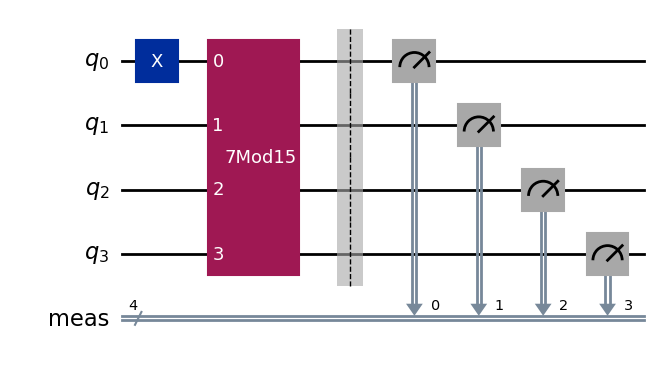

In [63]:
## Saisir votre code ici : 

#qcirc = QuantumCircuit(m)
def qcirc(n):
    circuit = QuantumCircuit(4)
    #######Ajouter votre code ici###########
    
    return circuit

print("{0:b}".format(3))
qcirc(1).draw('mpl')


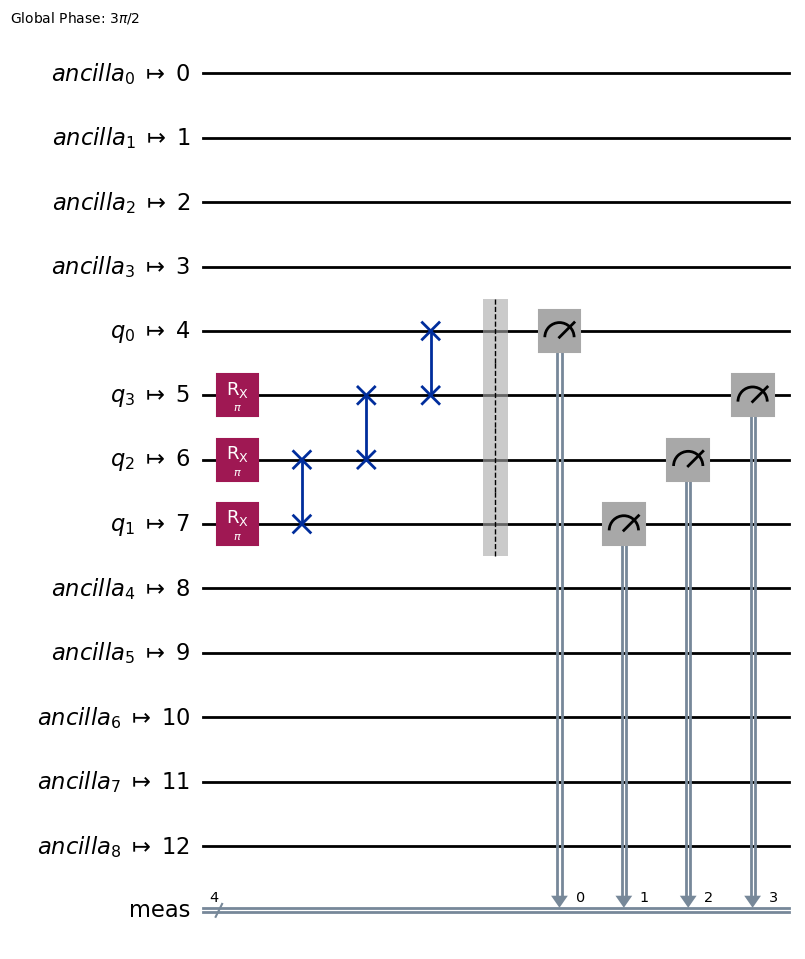

In [64]:
###Backend
#backend = AerSimulator.from_backend(FakeSydneyV2()) ###IBM's fake backend
qcirc1 = transpile(qcirc(1), backend)
qcirc1.draw('mpl')

In [65]:
## Exécuter cette cellule pour simuler 'qpe4' et tracer l'histogramme du résultat

input_1 = AerSimulator().run(qcirc1, shots=2000).result()
print(input_1)

### Étape 2. Mise en oeuvre de $U^{2^{m-1}}$.

Nous allons maintenant utiliser ce $U contrôlé$ pour estimer la phase $\phi=\frac{s}{r}$.  Mais d'abord, un petit point à noter ici.  Il s'avère qu'une séquence de portes `7Mod15` produit l'identité lorsqu'elle est exécutée un multiple de 4 fois.  Pour tester cela, créez un circuit quantique implémentant la porte `7mod15` $2^2$ fois et exécutez-le sur le backend `unitary_simulator` pour obtenir la représentation matricielle des portes dans le circuit.  Vérifiez que $U^{2^2}=I$.

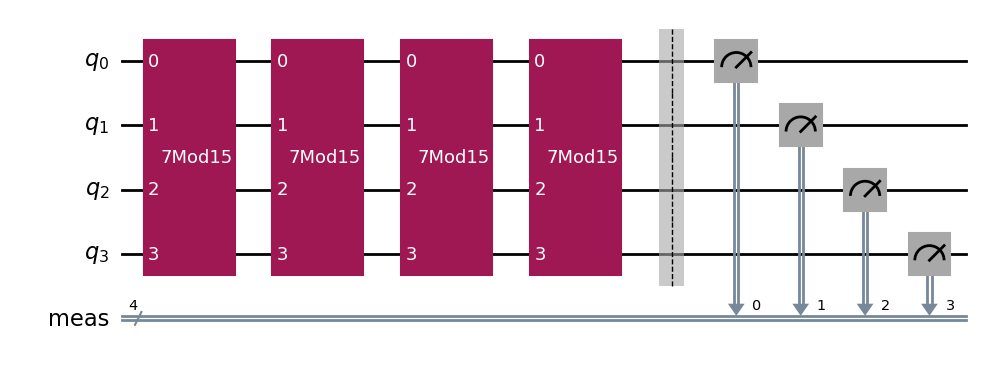

In [66]:

unitary_circ = QuantumCircuit(m)
# Votre code ici



### Étape 3. Trouver $\phi$ et des fractions continues


Maintenant que nous disposons d'un moyen d'exécuter $U^{2^{m-1}}$, utilisons-le dans le circuit QPE que vous avez créé plus tôt.  Vous trouverez ci-dessous une fonction permettant de construire une porte $U$ contrôlée. Utilisez $8$ qubits pour le registre de phase et 4 qubits pour le registre sur lequel $U$ agira, en utilisant à nouveau le `aer_simulator`, estimez la phase $\phi$ étant donné un état d'entrée de $|1\rangle{}$.

*Astuce : à chaque étape du circuit QPE, vous devrez construire un nouveau circuit `cU_multi` et l'ajouter au circuit QPE. Il y aura plusieurs estimations qui auront approximativement la même probabilité.*

In [68]:
#This function will return a ControlledGate object which repeats the action
# of U, 2^k times
def cU_multi(k):
    sys_register_size = 4
    circ = QuantumCircuit(sys_register_size)
    for _ in range(2**k):
        circ.append(U, range(sys_register_size))
    
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)
    
    cU_multi = U_multi.control()
    return cU_multi

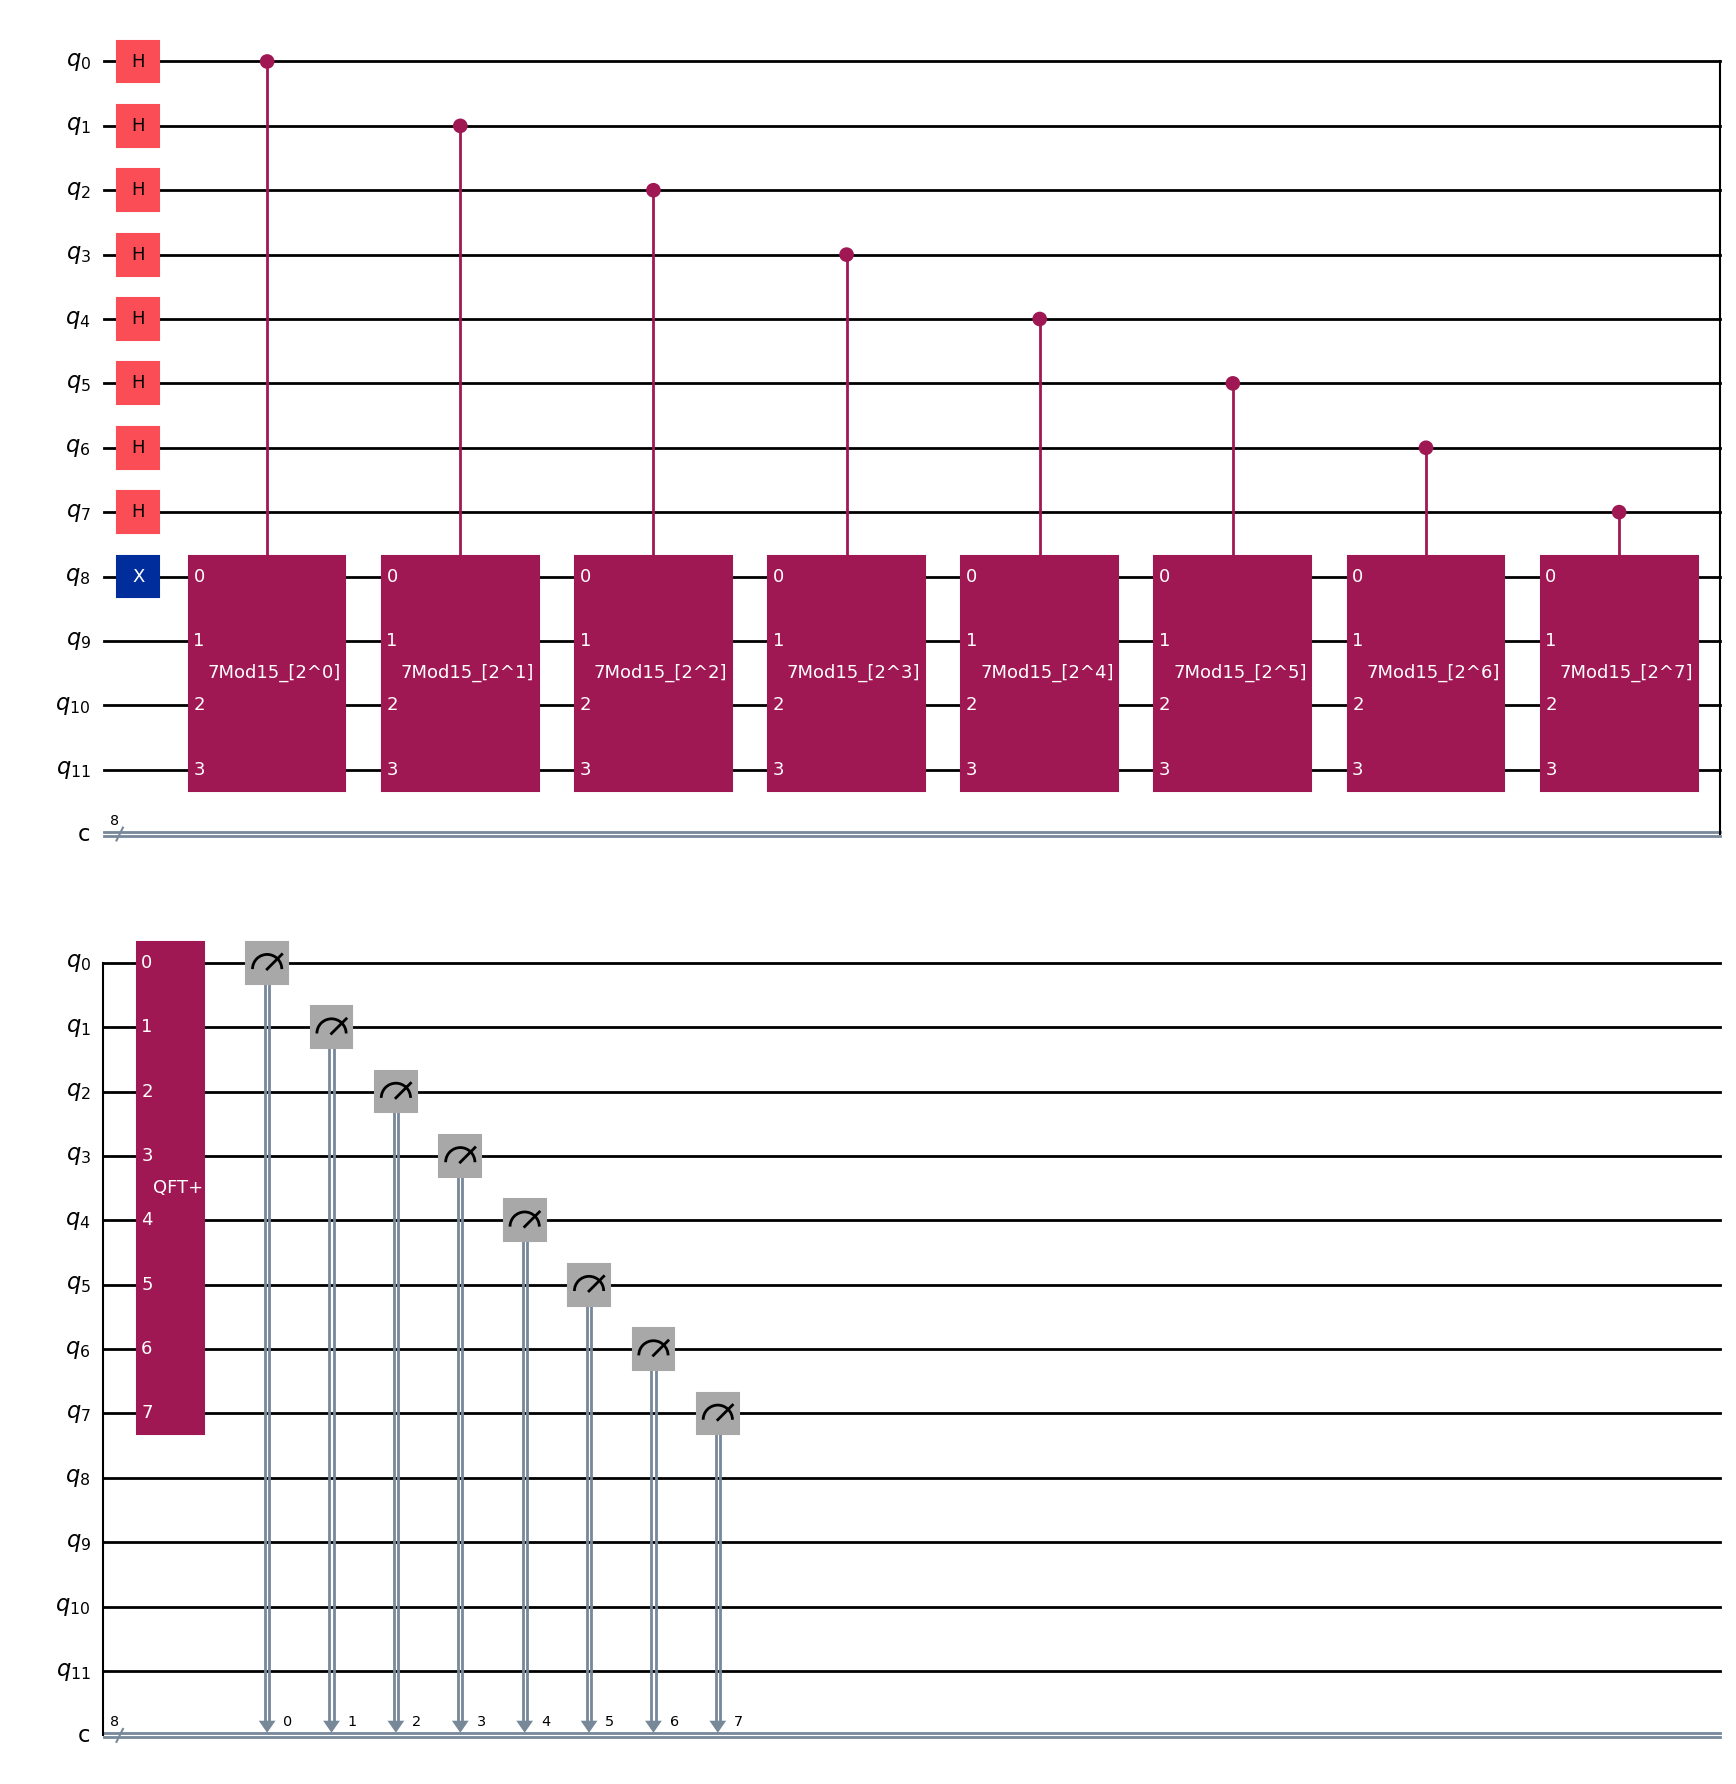

In [69]:
##Créer le circuit quantique nécessaire pour fonctionner avec 8 qubits de registre de phase
### Votre code ici###


In [70]:
### Transpile pour shor_qpe
transpile_shor_qpe = transpile(shor_qpe, backend)
result_shor_qpe = AerSimulator().run(transpile_shor_qpe, shots=2000).result()
#result = AerSimulator().run(qc, shots = 1000).result()

shor_qpe_counts = result_shor_qpe.get_counts()

Nous pouvons alors trouver les entiers $s$ et $r$ en utilisant l'algorithme des fractions continues.  Heureusement, Python dispose d'une fonctionnalité intégrée pour cela, en utilisant la fonction `Fraction`, où nous limiterons le dénominateur à $r<15$.  Utilisez cette fonction pour trouver les estimations $s$ et $r$ pour chaque résultat que vous avez mesuré ci-dessus.

In [71]:
from fractions import Fraction
print(Fraction(0.666), '\n')
print(Fraction(0.666).limit_denominator(15))

5998794703657501/9007199254740992 

2/3


In [72]:

# create a list of Fraction objects for each measurement outcome
shor_qpe_fractions = []
for outcome in shor_qpe_counts:
    print(outcome)
    decimal = int(outcome, 2) #Convert binary string to decimal
    phase = decimal/2**8      #The corresponding phase
    frac = Fraction(phase).limit_denominator(15)
    shor_qpe_fractions.append(frac)
print(shor_qpe_fractions)

11000000
01000000
10000000
00000000
[Fraction(3, 4), Fraction(1, 4), Fraction(1, 2), Fraction(0, 1)]


### Étape 4. Mettre tout cela ensemble

Mettons maintenant toutes ces étapes ensemble afin de factoriser le nombre (très simple), $N = 15$.  Nous allons continuer avec notre exemple de $a=7$, rappelons que la phase que nous mesurons $s/r$ où $s$ est un entier aléatoire entre $0$ et $r-1$ et :

$$
 a^r\text{mod}N = 1
$$

Ensuite, une fois que nous avons $r$, nous pouvons trouver un facteur de $N$ par :

$$
 \left(a^r-1\right)\text{mod} N = 0
$$
qui exige que $N$ soit divisé par $a^r-1$.  Si $r$ est pair, on peut aussi écrire

$$
 a^r-1 = \left(a^{r/2}+1\right)\left(a^{r/2}-1\right).
$$

Créez une fonction appelée `shor_qpe` qui prend un argument pour $k$ (le nombre de qubits de comptage) et compose, exécute et traite l'algorithme de Shor pour deviner les facteurs.  Utilisez un état d'entrée de $|y\rangle{}=|1\rangle{}$ pour l'estimation de la phase. (Note : La fonction `cU_multi()` n'exécute que $|ay \text{mod}\ 15\rangle{}$ pour $a=7$)

In [73]:
def shor_qpe(k):

    a = 7
    N = 15
    #Step 1. Begin a while loop until a nontrivial guess is found
    ### Your code goes here ###
    attemp = 0
    factor_found = False
    while not factor_found:
        attemp += 1

        #Step 2a. Construct a QPE circuit with m phase count qubits
        #  to guess the phase phi = s/r using the function cU_multi()
        ### Your code goes here ###
        shor_qpe = QuantumCircuit(k+4,k)
        for i in range(k):
            shor_qpe.h(i)
        shor_qpe.x(k)    

        for i in range(k):
            shor_qpe.append(cU_multi(i),[i]+[l+k for l in range(4)]) 

        qft_dag = qft(k).inverse()
        qft_dag.name = 'QFT+'

        shor_qpe.append(qft_dag, range(k))
        shor_qpe.measure(range(k),range(k))

        #Step 2b. Run the QPE circuit with a single shot, record the results
        # and convert the estimated phase bitstring to decimal
        ### Your code goes here ###
        transpile_shor_qpe = transpile(shor_qpe, backend)
        result_shor_qpe = AerSimulator().run(transpile_shor_qpe, shots=2000).result()
        shor_qpe_counts = result_shor_qpe.get_counts()
        
        decimal = int(next(iter(shor_qpe_counts)),2) #Convert binary string to decimal
        phase = decimal/2**k      #The corresponding phase

        

        #Step 3. Use the Fraction object to find the guess for r
        ### Your code goes here ###
        frac = Fraction(phase).limit_denominator(15)
        r = frac.denominator

        #Step 4. Now that r has been found, use the builtin greatest common deonominator
        # function to determine the guesses for a factor of N
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]

        #Step 5. For each guess in guesses, check if at least one is a non-trivial factor
        # i.e.  (guess != 1 or N) and (N % guess == 0)
        ### Your code goes here ###
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: 
                print ("Non-trivial factor found")
                factor_found = True
        
    
    #Step 6. If a nontrivial factor is found return the list 'guesses', otherwise
    # continue the while loop
    ### Your code goes here ###
    
    return guesses
print(shor_qpe(8))

Non-trivial factor found
Non-trivial factor found
[3, 5]


### La dernière étape, Refaites tout en utilisant Callisto comme le backend

Félicitations ! Vous avez déchiffré le fameux algorithme de Shor pour factoriser les entiers . 